# Multi-Class Classifier on Particle Track Data

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import math

## Get angle values and cast to boolean

In [3]:
track_params = pd.read_csv('../TRAIN/track_parms.csv')

In [4]:
track_params.tail()

,filename,phi,z,phi_calc,phi_regression,sigma_regression
499995,img499995.png,-4.509653,0.968584,-4.494071,-4.494040,0.014105
499996,img499996.png,-1.595661,-7.397094,-1.645501,-1.645483,0.014181
499997,img499997.png,7.695264,-2.984060,7.799254,7.799186,0.013931
499998,img499998.png,-1.898667,5.082713,-1.880849,-1.880834,0.014177
499999,img499999.png,4.275843,-2.266920,4.324348,4.324317,0.014112


## Create our simple classification target

In [21]:
# Bin the phi values to get multi-class labels
track_params['phi_binned'], phi_bins = pd.cut(track_params.phi,
                                              bins=range(-10, 12, 2),
                                              retbins=True)
track_params['phi_binned'] = track_params['phi_binned'].astype(str)

In [22]:
track_params.head()

,filename,phi,z,phi_calc,phi_regression,sigma_regression,phi_binned
0,img000000.png,-0.195900,-5.164839,-0.206930,-0.206928,0.014192,"(-2, 0]"
1,img000001.png,-1.473349,5.784543,-1.409622,-1.409614,0.014184,"(-2, 0]"
2,img000002.png,9.206585,-2.295192,9.296442,9.296330,0.016293,"(8, 10]"
3,img000003.png,5.378890,4.685070,5.281532,5.281474,0.014072,"(4, 6]"
4,img000004.png,-6.700401,-0.851756,-6.739551,-6.739504,0.013997,"(-8, -6]"


## Create an image generator from this dataframe

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
DATAGEN = ImageDataGenerator(rescale=1./255.,
                             validation_split=0.25)

In [25]:
height = 100
width = 36

def create_generator(target, subset, class_mode,
                     idg=DATAGEN, df=track_params, N=1000):
    
    return idg.flow_from_dataframe(
        dataframe=track_params.head(N),
        directory="../TRAIN",
        x_col="filename",
        y_col=target,
        subset=subset,
        target_size=(height, width),
        batch_size=32,
        seed=314,
        shuffle=True,
        class_mode=class_mode,
    )

## Create a very simple convolutional model from scratch

In [26]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, Activation, MaxPooling2D,
    Flatten, Dense, Dropout, Input
)

## Okay, maybe that was too easy

* I mean, if any pixels are lit up on the top half / bottom half, it's a smoking gun.
* Let's make it harder with binned measurements and treat it as categorical.

In [27]:
mc_train_generator = create_generator(
    target="phi_binned",
    subset="training",
    class_mode="categorical",
    N=10000
)
mc_val_generator = create_generator(
    target="phi_binned",
    subset="validation",
    class_mode="categorical",
    N=10000
)

Found 7500 validated image filenames belonging to 10 classes.
Found 2500 validated image filenames belonging to 10 classes.


## Similar model, with some tweaks

In [28]:
width  = 36
height = 100
channels = 3

def multiclass_classifier():
    model = Sequential()

    # Convoluional Layer
    model.add(Conv2D(32, (3, 3), input_shape=(height, width, channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Dense, Classification Layer
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [29]:
STEP_SIZE_TRAIN = mc_train_generator.n//mc_train_generator.batch_size
STEP_SIZE_VAL = mc_val_generator.n//mc_val_generator.batch_size

In [30]:
mc_model = multiclass_classifier()
mc_history = mc_model.fit_generator(
    generator=mc_train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=mc_val_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=10
)

Epoch 1/10
234/234 [==============================] - 8s 34ms/step - loss: 0.2956 - accuracy: 0.9138 - val_loss: 0.0671 - val_accuracy: 0.9736
Epoch 2/10
234/234 [==============================] - 7s 28ms/step - loss: 0.1325 - accuracy: 0.9530 - val_loss: 0.0523 - val_accuracy: 0.9788
Epoch 3/10
234/234 [==============================] - 7s 28ms/step - loss: 0.0960 - accuracy: 0.9657 - val_loss: 0.0428 - val_accuracy: 0.9836
Epoch 4/10
234/234 [==============================] - 7s 29ms/step - loss: 0.0875 - accuracy: 0.9680 - val_loss: 0.0397 - val_accuracy: 0.9848
Epoch 5/10
234/234 [==============================] - 7s 29ms/step - loss: 0.0824 - accuracy: 0.9697 - val_loss: 0.0370 - val_accuracy: 0.9844
Epoch 6/10
234/234 [==============================] - 7s 30ms/step - loss: 0.0783 - accuracy: 0.9695 - val_loss: 0.0334 - val_accuracy: 0.9856
Epoch 7/10
234/234 [==============================] - 7s 29ms/step - loss: 0.0766 - accuracy: 0.9716 - val_loss: 0.0270 - val_accuracy: 0.9900

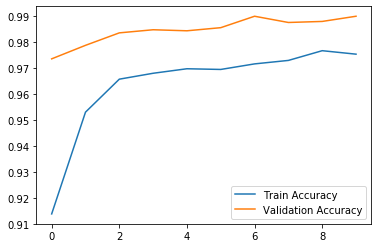

In [31]:
plt.plot(mc_history.history['accuracy'], label="Train Accuracy")
plt.plot(mc_history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.show()

## Check out predictions on Holdout data

In [32]:
holdout_track_params = pd.read_csv('../VALIDATION/track_parms.csv')

holdout_track_params['phi_binned'] = pd.cut(
    holdout_track_params['phi'],
    bins=phi_bins
)
holdout_track_params['phi_binned'] = (
    holdout_track_params['phi_binned'].astype(str)
)

In [33]:
mc_holdout_generator = DATAGEN.flow_from_dataframe(
    dataframe=holdout_track_params,
    directory="../VALIDATION",
    x_col="filename",
    y_col="phi_binned",
    subset=None,
    target_size=(height, width),
    batch_size=32,
    seed=314,
    shuffle=False,
    class_mode="categorical",
)

Found 50000 validated image filenames belonging to 10 classes.


In [34]:
holdout_track_params['y_pred'] = mc_model.predict_classes(mc_holdout_generator)

In [35]:
holdout_track_params['y_true'] = mc_holdout_generator.classes

In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

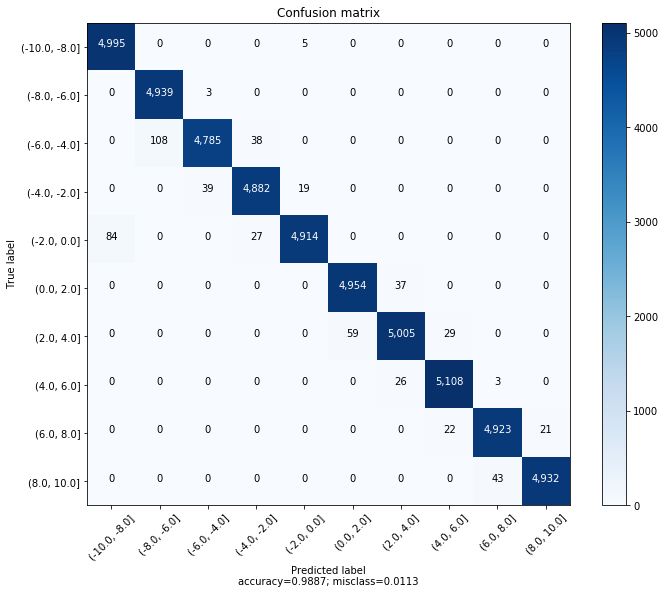

In [37]:
y_pred = mc_model.predict_classes(mc_holdout_generator)
y_true = mc_holdout_generator.labels

label_list = ['(-10.0, -8.0]', '(-8.0, -6.0]', '(-6.0, -4.0]', '(-4.0, -2.0]',
              '(-2.0, 0.0]', '(0.0, 2.0]', '(2.0, 4.0]', '(4.0, 6.0]', '(6.0, 8.0]',
              '(8.0, 10.0]']
plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      target_names=label_list,
                      normalize=False)